In [1]:
# ECE60146 HW8
# Zhengxin Jiang
# jiang839

import numpy as np
import os
import matplotlib.pyplot as plt
import random
import json
import math
import seaborn as sn 
import gzip
import pickle
import gensim.downloader as genapi
from gensim.models import KeyedVectors 
import sys

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
import torchvision.transforms as tvt
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [26]:

## HW8 Dataset
## The implementation from DLStudio
class SentimentAnalysisDataset(torch.utils.data.Dataset):
    def __init__(self, train_or_test, dataset_file, path_to_saved_embeddings=None):
        super().__init__()

        self.path_to_saved_embeddings = path_to_saved_embeddings
        self.train_or_test = train_or_test
        f = gzip.open(dataset_file, 'rb')
        dataset = f.read()
        if path_to_saved_embeddings is not None:
            if os.path.exists(path_to_saved_embeddings + 'vectors.kv'):
                self.word_vectors = KeyedVectors.load(path_to_saved_embeddings + 'vectors.kv')
            else:
                print("""\n\nSince this is your first time to install the word2vec embeddings, it may take"""
                      """\na couple of minutes. The embeddings occupy around 3.6GB of your disk space.\n\n""")
                self.word_vectors = genapi.load("word2vec-google-news-300")               
                ##  'kv' stands for  "KeyedVectors", a special datatype used by gensim because it 
                ##  has a smaller footprint than dict
                self.word_vectors.save(path_to_saved_embeddings + 'vectors.kv')    
        if train_or_test == 'train':
            if sys.version_info[0] == 3:
                self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset, encoding='latin1')
            else:
                self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset)
            self.categories = sorted(list(self.positive_reviews_train.keys()))
            self.category_sizes_train_pos = {category : len(self.positive_reviews_train[category]) for category in self.categories}
            self.category_sizes_train_neg = {category : len(self.negative_reviews_train[category]) for category in self.categories}
            self.indexed_dataset_train = []
            for category in self.positive_reviews_train:
                for review in self.positive_reviews_train[category]:
                    self.indexed_dataset_train.append([review, category, 1])
            for category in self.negative_reviews_train:
                for review in self.negative_reviews_train[category]:
                    self.indexed_dataset_train.append([review, category, 0])
            random.shuffle(self.indexed_dataset_train)
        elif train_or_test == 'test':
            if sys.version_info[0] == 3:
                self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset, encoding='latin1')
            else:
                self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset)
            self.vocab = sorted(self.vocab)
            self.categories = sorted(list(self.positive_reviews_test.keys()))
            self.category_sizes_test_pos = {category : len(self.positive_reviews_test[category]) for category in self.categories}
            self.category_sizes_test_neg = {category : len(self.negative_reviews_test[category]) for category in self.categories}
            self.indexed_dataset_test = []
            for category in self.positive_reviews_test:
                for review in self.positive_reviews_test[category]:
                    self.indexed_dataset_test.append([review, category, 1])
            for category in self.negative_reviews_test:
                for review in self.negative_reviews_test[category]:
                    self.indexed_dataset_test.append([review, category, 0])
            random.shuffle(self.indexed_dataset_test)

    def review_to_tensor(self, review):
        list_of_embeddings = []
        for i,word in enumerate(review):
            if word in self.word_vectors.key_to_index:
                embedding = self.word_vectors[word]
                list_of_embeddings.append(np.array(embedding))
            else:
                next
        review_tensor = torch.FloatTensor( list_of_embeddings )
        return review_tensor

    def sentiment_to_tensor(self, sentiment):
        """
        Sentiment is ordinarily just a binary valued thing.  It is 0 for negative
        sentiment and 1 for positive sentiment.  We need to pack this value in a
        two-element tensor.
        """        
        sentiment_tensor = torch.zeros(2)
        if sentiment == 1:
            sentiment_tensor[1] = 1
        elif sentiment == 0: 
            sentiment_tensor[0] = 1
        sentiment_tensor = sentiment_tensor.type(torch.long)
        return sentiment_tensor

    def __len__(self):
        if self.train_or_test == 'train':
            return len(self.indexed_dataset_train)
        elif self.train_or_test == 'test':
            return len(self.indexed_dataset_test)

    def __getitem__(self, idx):
        sample = self.indexed_dataset_train[idx] if self.train_or_test == 'train' else self.indexed_dataset_test[idx]
        review = sample[0]
        review_category = sample[1]
        review_sentiment = sample[2]
        review_sentiment = self.sentiment_to_tensor(review_sentiment)
        review_tensor = self.review_to_tensor(review)
        category_index = self.categories.index(review_category)
        sample = {'review'       : review_tensor, 
                  'category'     : category_index, # should be converted to tensor, but not yet used
                  'sentiment'    : review_sentiment }
        return sample
    

## RNN net
class HW8Net(nn.Module):
    
    def __init__(self, task, input_size, hidden_size, output_size, num_layers=1, batch_size=1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.task = task
        
        self.gru = GRU(input_size, hidden_size, output_size)
        self.nngru = nn.GRU(input_size, hidden_size, num_layers)
        self.gru_bi = nn.GRU(input_size, hidden_size, num_layers, bidirectional=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc_bi = nn.Linear(hidden_size*2, output_size)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        if self.task == 'gru':
            out, h = self.gru(x, h)
            out = self.fc(self.relu(out[:,-1]))
        
        if self.task == 'gru_nn':
            out, h = self.nngru(x, h)
            out = self.fc(self.relu(out[:,-1]))
        
        if self.task == 'gru_nn_bi':
            out, h = self.gru_bi(x, h)
            out = self.fc_bi(self.relu(out[:,-1]))
        
        out = self.logsoftmax(out)
        return out, h

    def init_hidden(self):
        weight = next(self.parameters()).data
        
        if self.task == 'gru' or self.task == 'gru_nn':
            hidden = weight.new(self.num_layers, self.batch_size, self.hidden_size).zero_()
        if self.task == 'gru_nn_bi':
            hidden = weight.new(self.num_layers*2, self.batch_size, self.hidden_size).zero_()
            
        return hidden
    
    
## GRU Unit
class GRU(nn.Module):
        
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        ## for forget gate:
        self.project1 = nn.Sequential( nn.Linear(input_size + hidden_size, hidden_size), nn.Sigmoid() )
        ## for interim out:
        self.project2 = nn.Sequential( nn.Linear(input_size + hidden_size, hidden_size), nn.Tanh() ) 
        ## for final out
        self.project3 = nn.Sequential( nn.Linear(hidden_size, output_size), nn.Tanh() )                   
    
    def forward(self, x, h, sequence_end=False):
        combined1 = torch.cat((x, h), 2)
        forget_gate = self.project1(combined1)  
        interim =  forget_gate * h
        combined2  = torch.cat((x, interim), 2)
        output_interim =  self.project2( combined2 )
        output = (1 - forget_gate) * h  +  forget_gate * output_interim
        if sequence_end == False:
            return output, output
        else:
            final_out = self.project3(output)
            return final_out, final_out
        
        
        

In [11]:
traindataset = SentimentAnalysisDataset('train', 'sentiment_dataset_train_400.tar.gz', 'D:/coco/hw8/')
traindataloader = DataLoader(traindataset, batch_size=1, num_workers=0, shuffle=True)

In [28]:
## Training ##
net = HW8Net('gru', 300, 100, 2, num_layers=1)
net = net.to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99))

train_loss = []

for epoch in range(5):
    running_loss = 0.0
    
    for i, data in enumerate(traindataloader):
        review_tensor, category, sentiment = data['review'], data['category'], data['sentiment']
        review_tensor = review_tensor.to(device)
        sentiment = sentiment.to(device)
        
        optimizer.zero_grad()
        hidden = net.init_hidden().to(device)
        
        for k in range(review_tensor.shape[1]):
            output, hidden = net(torch.unsqueeze(torch.unsqueeze(review_tensor[0,k],0),0), hidden)
        
        loss = criterion(output, torch.argmax(sentiment, 1))
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        if i % 200 == 199:    
            avg_loss = running_loss / float(200)
            train_loss.append(avg_loss)
            print("[epoch:%d  iter:%4d  ]     loss: %.5f" % (epoch+1,i+1, avg_loss))
            running_loss = 0.0

[epoch:1  iter: 200  ]     loss: 0.69667
[epoch:1  iter: 400  ]     loss: 0.67832
[epoch:1  iter: 600  ]     loss: 0.66541
[epoch:1  iter: 800  ]     loss: 0.65982
[epoch:1  iter:1000  ]     loss: 0.64180
[epoch:1  iter:1200  ]     loss: 0.81551
[epoch:1  iter:1400  ]     loss: 0.63168
[epoch:1  iter:1600  ]     loss: 0.64503
[epoch:1  iter:1800  ]     loss: 0.61235
[epoch:1  iter:2000  ]     loss: 0.53834
[epoch:1  iter:2200  ]     loss: 0.60780
[epoch:1  iter:2400  ]     loss: 0.63011
[epoch:1  iter:2600  ]     loss: 0.65545
[epoch:1  iter:2800  ]     loss: 0.66547
[epoch:1  iter:3000  ]     loss: 0.58641
[epoch:1  iter:3200  ]     loss: 0.57232
[epoch:1  iter:3400  ]     loss: 0.56159
[epoch:1  iter:3600  ]     loss: 0.59934
[epoch:1  iter:3800  ]     loss: 0.54613
[epoch:1  iter:4000  ]     loss: 0.52621
[epoch:1  iter:4200  ]     loss: 0.52500
[epoch:1  iter:4400  ]     loss: 0.50032
[epoch:1  iter:4600  ]     loss: 0.49956
[epoch:1  iter:4800  ]     loss: 0.51561
[epoch:1  iter:5

[epoch:3  iter:11600  ]     loss: 0.29109
[epoch:3  iter:11800  ]     loss: 0.21160
[epoch:3  iter:12000  ]     loss: 0.22635
[epoch:3  iter:12200  ]     loss: 0.23505
[epoch:3  iter:12400  ]     loss: 0.19692
[epoch:3  iter:12600  ]     loss: 0.16989
[epoch:3  iter:12800  ]     loss: 0.20078
[epoch:3  iter:13000  ]     loss: 0.25077
[epoch:3  iter:13200  ]     loss: 0.16880
[epoch:3  iter:13400  ]     loss: 0.26668
[epoch:3  iter:13600  ]     loss: 0.21038
[epoch:3  iter:13800  ]     loss: 0.24472
[epoch:3  iter:14000  ]     loss: 0.19656
[epoch:3  iter:14200  ]     loss: 0.33234
[epoch:4  iter: 200  ]     loss: 0.15793
[epoch:4  iter: 400  ]     loss: 0.16081
[epoch:4  iter: 600  ]     loss: 0.09424
[epoch:4  iter: 800  ]     loss: 0.18710
[epoch:4  iter:1000  ]     loss: 0.26466
[epoch:4  iter:1200  ]     loss: 0.13302
[epoch:4  iter:1400  ]     loss: 0.16912
[epoch:4  iter:1600  ]     loss: 0.18077
[epoch:4  iter:1800  ]     loss: 0.12951
[epoch:4  iter:2000  ]     loss: 0.17035
[e

In [29]:
## save models
torch.save(net.state_dict(), 'gru.pth')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


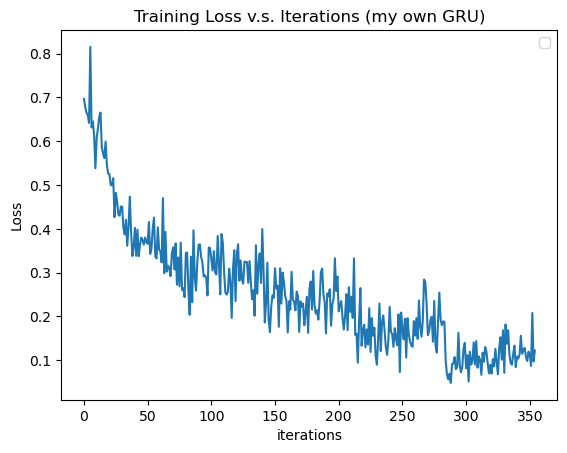

In [31]:
## plot the loss
plt.figure()
plt.title("Training Loss v.s. Iterations (my own GRU)")
plt.plot(train_loss)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [32]:
## Testing ##
testdataset = SentimentAnalysisDataset('test', 'sentiment_dataset_test_400.tar.gz', 'D:/coco/hw8/')
testdataloader = DataLoader(testdataset, batch_size=1, num_workers=0, shuffle=True)

cm = torch.zeros(2,2)

with torch.no_grad():
    for i, data in enumerate(testdataloader):
        review_tensor,category,sentiment = data['review'], data['category'], data['sentiment']
        review_tensor = review_tensor.to(device)
        sentiment = sentiment.to(device)
        hidden = net.init_hidden().to(device)
        
        for k in range(review_tensor.shape[1]):
            output, hidden = net(torch.unsqueeze(torch.unsqueeze(review_tensor[0,k],0),0), hidden)
        predicted_idx = torch.argmax(output).item()
        gt_idx = torch.argmax(sentiment).item()
        
        ## update confusion matrix
        cm[gt_idx, predicted_idx] += 1
        
acc = (cm[0,0]+cm[1,1])/len(testdataloader)

<Axes: title={'center': 'Confusion Matrix of Validation (my own GRU), acc=0.873'}>

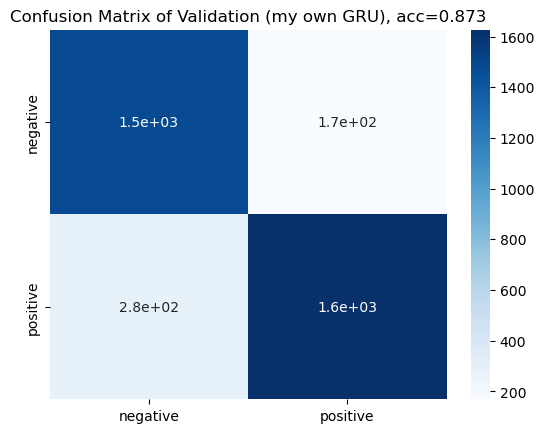

In [33]:
plt.figure()
plt.title("Confusion Matrix of Validation (my own GRU), acc=%.3f" % (acc)) 
sn.heatmap(cm, annot=True, cmap="Blues",xticklabels=['negative','positive'], yticklabels=['negative','positive'])